# Q Learning (Off Policy) with experience replay

We will be using **TD control method of Q Learning** on Cliff World environment as given below:  

![GridWorld](./figs/cliffworld.png "Cliff World")


### Q Learning Update equation (remains same)

Q Learning control is carried by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. The Update equation is given below:

$$ 
\text{max} Q(S,A) \leftarrow Q(S,A) + \alpha \cdot [ R + \gamma \cdot \max_{A'} Q(S’,A’) – Q(S,A)] 
$$


In experience replay, we store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using Q-values. Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. The process makes learning efficient by reusing a sample multiple times. Rest of the approach remains same. 

#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
## uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle
# !apt-get update 
# !apt-get install -y swig cmake ffmpeg freeglut3-dev xvfb

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle

## Uncomment and run for Colab
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /content/drl-2ed 
# !pip install  -r requirements.txt
# %cd chapter4


## Uncomment and run for Kaggle
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /kaggle/working/drl-2ed 
# !pip install  -r requirements.txt
# %cd chapter4

In [ ]:
## Uncomment and Rerun the cd command in case you were asked to restart the kernel and you followed that message
## as after resart the kernel will again point back to root folder


## Uncomment and run for Colab
# %cd /content/drl-2ed 
# %cd chapter6


## Uncomment and run for Kaggle
# %cd /kaggle/working/drl-2ed 
# %cd chapter6

In [1]:
# Initial imports and environment setup
import gymnasium as gym
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from IPython.display import HTML
from base64 import b64encode

%matplotlib inline

In [2]:
# Q Learning Learning agent class
from collections import defaultdict


class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # Q learning update step
    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + self.gamma * \
                self.get_Q(next_state, best_next_action) - \
                self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get best A for Q(S,A) which maximizes the Q(S,a) for actions in state S
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy for exploration
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [3]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.xlabel("Episode number")
    plt.ylabel("Return per episode")
    plt.show()

In [4]:
# helper function to print policy under Cliff world
def print_policy(env, agent):

    _cliff = np.zeros(env.shape, dtype=bool)
    _cliff[3, 1:-1] = True    
    nR, nC = _cliff.shape

    actions = '^>v<'
    print("Policy learnt by Agent\n")    

    for y in range(nR):
        for x in range(nC):
            if _cliff[y, x]:
                print(" C ", end='')
            elif (y * nC + x) == env.start_state_index:
                print(" X ", end='')
            elif (y * nC + x) == nR * nC - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.max_action(y * nC + x)], end='')
        print()

#### Replay Buffer

In [5]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size  # max number of items in buffer
        self.buffer = []   # array to hold buffer

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        self.buffer = self.buffer[-self.size:] + [item]

    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return states, actions, rewards, next_states, done_flags

In [6]:
# training algorithm with reply buffer
def train_agent(env, agent, episode_cnt=10000, tmax=10000,
                anneal_eps=True, replay_buffer=None, batch_size=16):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state, _ = env.reset()
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)
            if replay_buffer:
                replay_buffer.add(state, action, reward, next_state, done)
                states, actions, rewards, next_states, done_flags = \
                        replay_buffer(batch_size)
                for i in range(batch_size):
                    agent.update(states[i], actions[i], rewards[i],
                                 next_states[i], done_flags[i])
            else:
                agent.update(state, action, reward, next_state, done)

            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
    return np.array(episode_rewards)

In [7]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])    
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()    
    for _ in range(video_length + 1):
        action = agent.max_action(obs[0])
        obs, _, _, _ = vec_env.step([action])
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]   
    # Save the video
    vec_env.close()
    return file_path

## Cliff Walking Q Learning with Experience Replay

#### Create Q Learning Agent for Cliff world environment and train agent

In [8]:
# create cliff world environment
env = gym.make("CliffWalking-v0")

In [9]:
# create a Q Learning agent
agent = QLearningAgent(alpha=0.25, epsilon=0.2, gamma=0.99, 
                       get_possible_actions=lambda s : range(env.nA))

# train agent using replay buffer and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt=5000, 
                      replay_buffer=ReplayBuffer(512))

/Users/ashis/venv-directory/venv-p310-RL-workspace/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nA to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nA` for environment variables or `env.get_wrapper_attr('nA')` that will search the reminding wrappers.
  logger.warn(


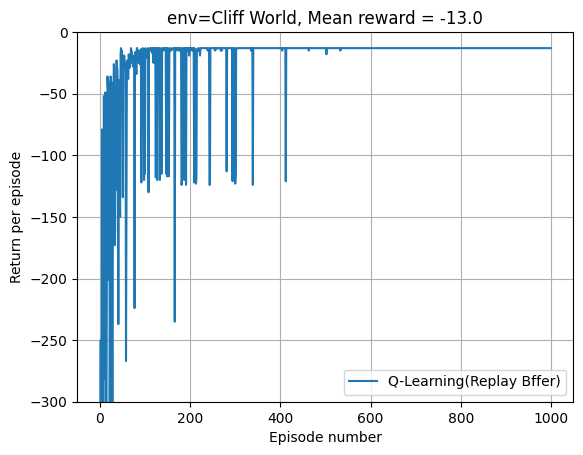

In [10]:
# plot per episode reward
plot_rewards("Cliff World", rewards[:1000], 'Q-Learning(Replay Bffer)')

#### Print Policy

In [11]:
# print policy learnt by the agent
print_policy(env, agent)

Policy learnt by Agent

 v  ^  >  v  >  >  ^  >  >  >  ^  v 
 ^  ^  >  >  ^  v  >  >  v  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


/Users/ashis/venv-directory/venv-p310-RL-workspace/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.shape to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.shape` for environment variables or `env.get_wrapper_attr('shape')` that will search the reminding wrappers.
  logger.warn(
/Users/ashis/venv-directory/venv-p310-RL-workspace/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.start_state_index to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.start_state_index` for environment variables or `env.get_wrapper_attr('start_state_index')` that will search the reminding wrappers.
  logger.warn(


#### Watch Trained Agent

In [12]:
env_id = "CliffWalking-v0"
video_folder = "logs/videos/"
video_length = 50
               
video_file = record_video(env_id, video_folder, video_length, agent)

/Users/ashis/venv-directory/venv-p310-RL-workspace/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nA to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nA` for environment variables or `env.get_wrapper_attr('nA')` that will search the reminding wrappers.
  logger.warn(


Saving video to /Users/ashis/Documents/Teaching/Reinforcement-Learning/Lectures/2024-lectures/drb-fall24-rl/week-07/logs/videos/QLearningAgent-CliffWalking-v0-step-0-to-step-50.mp4
Moviepy - Building video /Users/ashis/Documents/Teaching/Reinforcement-Learning/Lectures/2024-lectures/drb-fall24-rl/week-07/logs/videos/QLearningAgent-CliffWalking-v0-step-0-to-step-50.mp4.
Moviepy - Writing video /Users/ashis/Documents/Teaching/Reinforcement-Learning/Lectures/2024-lectures/drb-fall24-rl/week-07/logs/videos/QLearningAgent-CliffWalking-v0-step-0-to-step-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/ashis/Documents/Teaching/Reinforcement-Learning/Lectures/2024-lectures/drb-fall24-rl/week-07/logs/videos/QLearningAgent-CliffWalking-v0-step-0-to-step-50.mp4


/Users/ashis/venv-directory/venv-p310-RL-workspace/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nA to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nA` for environment variables or `env.get_wrapper_attr('nA')` that will search the reminding wrappers.
  logger.warn(


In [13]:
mp4 = open(video_file, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Q Learning agent with Experience Replay for "Taxi" environment


Let us now repeat all the above steps for another environment and train a Q-learning agent with experience replay

#### Create Q-learning agent and train with Experience Replay

In [14]:
# create taxi environment
env = gym.make("Taxi-v3")

# create a Q Learning agent
agent = QLearningAgent(alpha=0.25, epsilon=0.2, gamma=0.99,
                       get_possible_actions=lambda s : range(env.action_space.n))

#train agent with replay buffer and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt=5000, 
                      replay_buffer = ReplayBuffer(512))

#### Plot Rewards

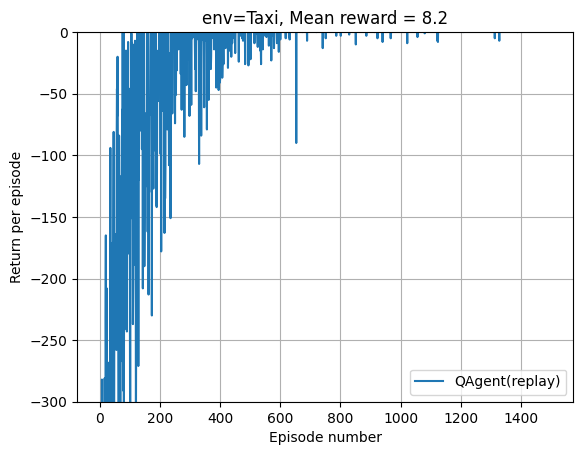

In [15]:
#plot reward graph
plot_rewards("Taxi", rewards[:1500], 'QAgent(replay)')

#### Watch Trained Agent

In [16]:
env_id = "Taxi-v3"
video_folder = "logs/videos/"
video_length = 200
               
video_file = record_video(env_id, video_folder, video_length, agent)

Saving video to /Users/ashis/Documents/Teaching/Reinforcement-Learning/Lectures/2024-lectures/drb-fall24-rl/week-07/logs/videos/QLearningAgent-Taxi-v3-step-0-to-step-200.mp4
Moviepy - Building video /Users/ashis/Documents/Teaching/Reinforcement-Learning/Lectures/2024-lectures/drb-fall24-rl/week-07/logs/videos/QLearningAgent-Taxi-v3-step-0-to-step-200.mp4.
Moviepy - Writing video /Users/ashis/Documents/Teaching/Reinforcement-Learning/Lectures/2024-lectures/drb-fall24-rl/week-07/logs/videos/QLearningAgent-Taxi-v3-step-0-to-step-200.mp4



Moviepy - Done !
Moviepy - video ready /Users/ashis/Documents/Teaching/Reinforcement-Learning/Lectures/2024-lectures/drb-fall24-rl/week-07/logs/videos/QLearningAgent-Taxi-v3-step-0-to-step-200.mp4


In [17]:
mp4 = open(video_file, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Conclusion

Q agent with replay buffer is supposed to improve the initial convergence by sampling repeatedly from the buffer. Sample efficiency will become more apparent when we look at DQN. Over long run, there won't be any significant difference between the optimal values learnt with or without Replay Buffer. It has another advantage of breaking correlation between samples. This aspect will also become apparent when we look at Deep Learning with Q-Learning i.e. DQN. 